# Reference envelop plots

Plots profiles reference envelop unsing PCM selection or not (as in Maze et al, 2017)

In [1]:
import xarray as xr
import numpy as np
import numpy.ma as ma
import pandas as pd

import pyxpcm
from pyxpcm.models import pcm

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

import cartopy.feature as cfeature
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import argopy
argopy.set_options(src='localftp', local_ftp='/home/coriolis_exp/spool/co05/co0508/')
from argopy import DataFetcher as ArgoDataFetcher
argo_loader = ArgoDataFetcher()

import scipy as sp
from scipy.io import loadmat
from scipy import interpolate

import seawater as sw

from classif_functions import *

In [2]:
def get_dataow(file_path):
    
    # load from .met file
    mat_dict_load = sp.io.loadmat(file_path)
    
    #create a xarray dataset
    ds_ref = xr.Dataset(
         data_vars=dict(
             pres=(["n_pres", "n_profiles"], mat_dict_load['la_bhist_pres']),
             ptmp=(["n_pres", "n_profiles"], mat_dict_load['la_bhist_ptmp']),
             sal=(["n_pres", "n_profiles"], mat_dict_load['la_bhist_sal']),
         ),
         coords=dict(
             long=(["n_profiles"], np.squeeze(mat_dict_load['la_bhist_long'])),
             lat=(["n_profiles"], np.squeeze(mat_dict_load['la_bhist_lat'])),
             dates=(["n_profiles"], pd.to_datetime(list(map(str, map(int, np.squeeze(mat_dict_load['la_bhist_dates'])))))),
         ),
     )

    return ds_ref

__Input__

In [3]:
float_WMO = 3901928
prof_num = 156

## 1. Load float profile

using argopy

In [4]:
argo_loader = ArgoDataFetcher()
    
ds_f = argo_loader.profile(float_WMO, prof_num).to_xarray()
ds_f = ds_f.argo.point2profile()

In [5]:
ds_f

<xarray.Dataset>
Dimensions:                (N_LEVELS: 97, N_PROF: 1)
Coordinates:
  * N_LEVELS               (N_LEVELS) int64 0 1 2 3 4 5 6 ... 91 92 93 94 95 96
    LONGITUDE              (N_PROF) float64 65.66
    LATITUDE               (N_PROF) float64 -47.03
  * N_PROF                 (N_PROF) int64 0
    TIME                   (N_PROF) datetime64[ns] 2021-03-07T04:44:00.000000256
Data variables:
    CONFIG_MISSION_NUMBER  (N_PROF) int64 2
    CYCLE_NUMBER           (N_PROF) int64 156
    DATA_MODE              (N_PROF) <U1 'D'
    DIRECTION              (N_PROF) <U1 'A'
    PLATFORM_NUMBER        (N_PROF) int64 3901928
    POSITION_QC            (N_PROF) int64 1
    PRES                   (N_PROF, N_LEVELS) float64 6.0 7.0 ... 2.002e+03
    PRES_QC                (N_PROF) int64 1
    PSAL                   (N_PROF, N_LEVELS) float64 33.74 33.74 ... 34.74
    PSAL_QC                (N_PROF) int64 1
    TEMP                   (N_PROF, N_LEVELS) float64 5.926 5.926 ... 1.56 1.541
    TEMP_QC                (N_PROF) int64 1
    TIME_QC                (N_PROF) int64 1
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         /home/coriolis_exp/spool/co05/co0508/
    Fetched_by:           agarciaj
    Fetched_date:         2021/09/01
    Fetched_constraints:  phy;WMO3901928_CYC156
    Fetched_uri:          /home/coriolis_exp/spool/co05/co0508//dac/coriolis/...
    history:              Variables filtered according to DATA_MODE; Variable...

In [6]:
pr = 0 # reference pressure in dbar
ds_f = ds_f.assign(ptmp=(["N_PROF", "N_LEVELS"], sw.ptmp(ds_f['PSAL'].values,ds_f['TEMP'].values,ds_f['PRES'].values,pr)))

In [7]:
ds_f

<xarray.Dataset>
Dimensions:                (N_LEVELS: 97, N_PROF: 1)
Coordinates:
  * N_LEVELS               (N_LEVELS) int64 0 1 2 3 4 5 6 ... 91 92 93 94 95 96
    LONGITUDE              (N_PROF) float64 65.66
    LATITUDE               (N_PROF) float64 -47.03
  * N_PROF                 (N_PROF) int64 0
    TIME                   (N_PROF) datetime64[ns] 2021-03-07T04:44:00.000000256
Data variables:
    CONFIG_MISSION_NUMBER  (N_PROF) int64 2
    CYCLE_NUMBER           (N_PROF) int64 156
    DATA_MODE              (N_PROF) <U1 'D'
    DIRECTION              (N_PROF) <U1 'A'
    PLATFORM_NUMBER        (N_PROF) int64 3901928
    POSITION_QC            (N_PROF) int64 1
    PRES                   (N_PROF, N_LEVELS) float64 6.0 7.0 ... 2.002e+03
    PRES_QC                (N_PROF) int64 1
    PSAL                   (N_PROF, N_LEVELS) float64 33.74 33.74 ... 34.74
    PSAL_QC                (N_PROF) int64 1
    TEMP                   (N_PROF, N_LEVELS) float64 5.926 5.926 ... 1.56 1.541
    TEMP_QC                (N_PROF) int64 1
    TIME_QC                (N_PROF) int64 1
    ptmp                   (N_PROF, N_LEVELS) float64 5.926 5.925 ... 1.411
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         /home/coriolis_exp/spool/co05/co0508/
    Fetched_by:           agarciaj
    Fetched_date:         2021/09/01
    Fetched_constraints:  phy;WMO3901928_CYC156
    Fetched_uri:          /home/coriolis_exp/spool/co05/co0508//dac/coriolis/...
    history:              Variables filtered according to DATA_MODE; Variable...

In [8]:
ds_f.PRES.max().values

array(2002.)

## 2. Load reference data

__data without class selection__

In [9]:
file_path = 'mat_files/' + str(float_WMO) + '_prof' + str(prof_num) + '_refdata.mat'
ds_ref = get_dataow(file_path)
ds_ref

<xarray.Dataset>
Dimensions:  (n_pres: 1008, n_profiles: 87)
Coordinates:
    long     (n_profiles) float64 65.37 65.19 65.36 65.42 ... 78.27 77.55 75.0
    lat      (n_profiles) float64 -49.56 -48.43 -48.32 ... -52.63 -54.06 -50.25
    dates    (n_profiles) datetime64[ns] 2015-01-01 2016-01-01 ... 2013-01-01
Dimensions without coordinates: n_pres, n_profiles
Data variables:
    pres     (n_pres, n_profiles) float64 4.3 4.7 4.1 4.3 ... nan nan nan nan
    ptmp     (n_pres, n_profiles) float64 3.54 5.3 6.306 6.466 ... nan nan nan
    sal      (n_pres, n_profiles) float64 33.85 33.79 33.77 ... nan nan nan

interpolation to standard levels

In [10]:
max_depth = 2000
std_lev = np.arange(0,max_depth)
ds_refi = interpolate_standard_levels(ds_ref, std_lev)
ds_refi

<xarray.Dataset>
Dimensions:            (PRES_INTERPOLATED: 2000, n_profiles: 4)
Coordinates:
    lat                (n_profiles) float64 -43.34 -46.21 -53.62 -54.06
    long               (n_profiles) float64 74.48 52.26 78.35 77.55
    dates              (n_profiles) datetime64[ns] 2009-01-01 ... 2016-01-01
  * PRES_INTERPOLATED  (PRES_INTERPOLATED) int64 0 1 2 3 ... 1996 1997 1998 1999
Dimensions without coordinates: n_profiles
Data variables:
    pres               (n_profiles, PRES_INTERPOLATED) float64 5.8 ... 1.999e+03
    ptmp               (n_profiles, PRES_INTERPOLATED) float64 11.06 ... 1.26
    sal                (n_profiles, PRES_INTERPOLATED) float64 34.87 ... 34.74

__data with class selection__

In [11]:
file_path = 'mat_files/' + str(float_WMO) + '_prof' + str(prof_num) + '_refdata_k3_class.mat'
ds_ref_class = get_dataow(file_path)
ds_ref_class

<xarray.Dataset>
Dimensions:  (n_pres: 1008, n_profiles: 64)
Coordinates:
    long     (n_profiles) float64 65.37 65.42 66.03 66.5 ... 78.27 77.55 75.0
    lat      (n_profiles) float64 -49.56 -48.09 -46.85 ... -52.63 -54.06 -50.25
    dates    (n_profiles) datetime64[ns] 2015-01-01 2016-01-01 ... 2013-01-01
Dimensions without coordinates: n_pres, n_profiles
Data variables:
    pres     (n_pres, n_profiles) float64 4.3 4.3 4.6 6.0 ... nan nan nan nan
    ptmp     (n_pres, n_profiles) float64 3.54 6.466 4.902 2.333 ... nan nan nan
    sal      (n_pres, n_profiles) float64 33.85 33.75 33.73 ... nan nan nan

interpolation to standard levels

In [12]:
max_depth = 2000
std_lev = np.arange(0,max_depth)
ds_ref_classi = interpolate_standard_levels(ds_ref_class, std_lev)
ds_ref_classi

<xarray.Dataset>
Dimensions:            (PRES_INTERPOLATED: 2000, n_profiles: 3)
Coordinates:
    lat                (n_profiles) float64 -46.21 -53.62 -54.06
    long               (n_profiles) float64 52.26 78.35 77.55
    dates              (n_profiles) datetime64[ns] 2013-01-01 ... 2016-01-01
  * PRES_INTERPOLATED  (PRES_INTERPOLATED) int64 0 1 2 3 ... 1996 1997 1998 1999
Dimensions without coordinates: n_profiles
Data variables:
    pres               (n_profiles, PRES_INTERPOLATED) float64 6.0 ... 1.999e+03
    ptmp               (n_profiles, PRES_INTERPOLATED) float64 5.622 ... 1.26
    sal                (n_profiles, PRES_INTERPOLATED) float64 33.81 ... 34.74

Calculate mean and std

In [13]:
mean_ptmp = np.nanmean(ds_refi['ptmp'], axis=0)
std_ptmp = np.nanstd(ds_refi['ptmp'], axis=0)
mean_sal = np.nanmean(ds_refi['sal'], axis=0)
std_sal = np.nanstd(ds_refi['sal'], axis=0)

mean_ptmp_class = np.nanmean(ds_ref_classi['ptmp'], axis=0)
std_ptmp_class = np.nanstd(ds_ref_classi['ptmp'], axis=0)
mean_sal_class = np.nanmean(ds_ref_classi['sal'], axis=0)
std_sal_class = np.nanstd(ds_ref_classi['sal'], axis=0)

## 3. Plots

__Potential temperature__

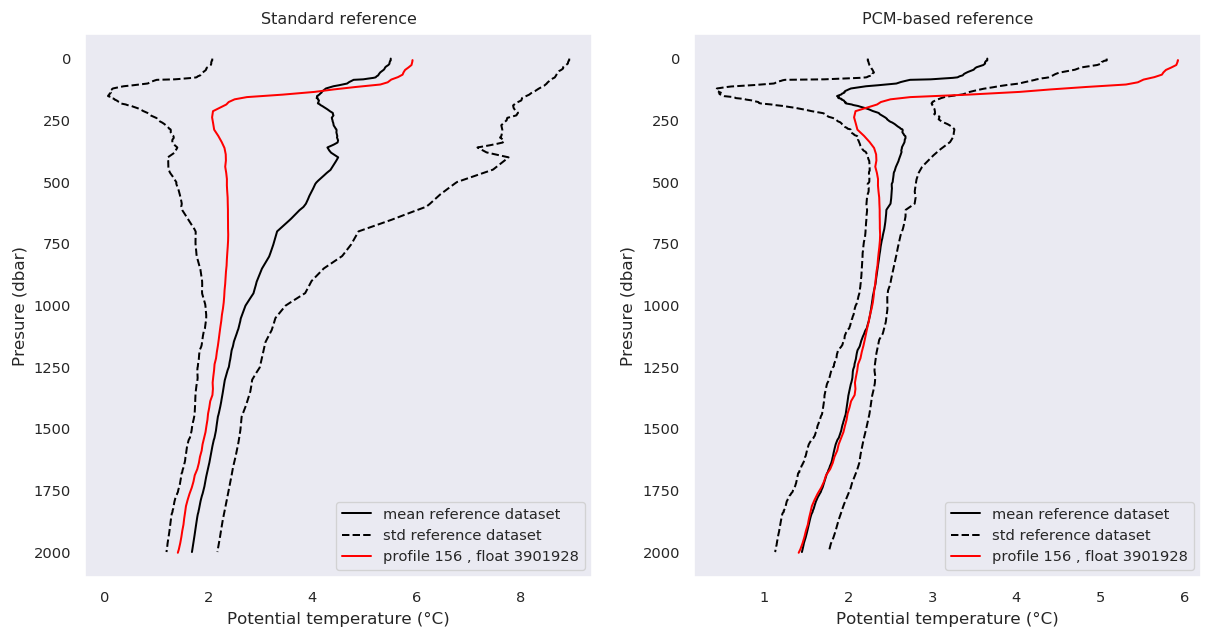

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(
            12, 6), dpi=120, facecolor='w', edgecolor='k')

ax[0].plot(mean_ptmp, ds_refi['PRES_INTERPOLATED'].values, 'k', label='mean reference dataset');
ax[0].plot(mean_ptmp + std_ptmp, ds_refi['PRES_INTERPOLATED'].values, 'k--', label='std reference dataset');
ax[0].plot(mean_ptmp - std_ptmp, ds_refi['PRES_INTERPOLATED'].values, 'k--');
ax[0].plot(ds_f['ptmp'].values[0], ds_f['PRES'].values[0], 'r', label='profile ' + str(prof_num)+ ' , float ' + str(float_WMO));
ax[0].invert_yaxis()
ax[0].set_ylabel('Presure (dbar)', fontsize=10);
ax[0].set_xlabel('Potential temperature (°C)', fontsize=10);
ax[0].set_title('Standard reference')
ax[0].legend()

ax[1].plot(mean_ptmp_class, ds_ref_classi['PRES_INTERPOLATED'].values, 'k', label='mean reference dataset');
ax[1].plot(mean_ptmp_class + std_ptmp_class, ds_ref_classi['PRES_INTERPOLATED'].values, 'k--', label='std reference dataset');
ax[1].plot(mean_ptmp_class - std_ptmp_class, ds_ref_classi['PRES_INTERPOLATED'].values, 'k--');
ax[1].plot(ds_f['ptmp'].values[0], ds_f['PRES'].values[0], 'r', label='profile ' + str(prof_num)+ ' , float ' + str(float_WMO));
ax[1].invert_yaxis()
ax[1].set_ylabel('Presure (dbar)', fontsize=10);
ax[1].set_xlabel('Potential temperature (°C)', fontsize=10);
ax[1].set_title('PCM-based reference')
ax[1].legend()

__Salinity__

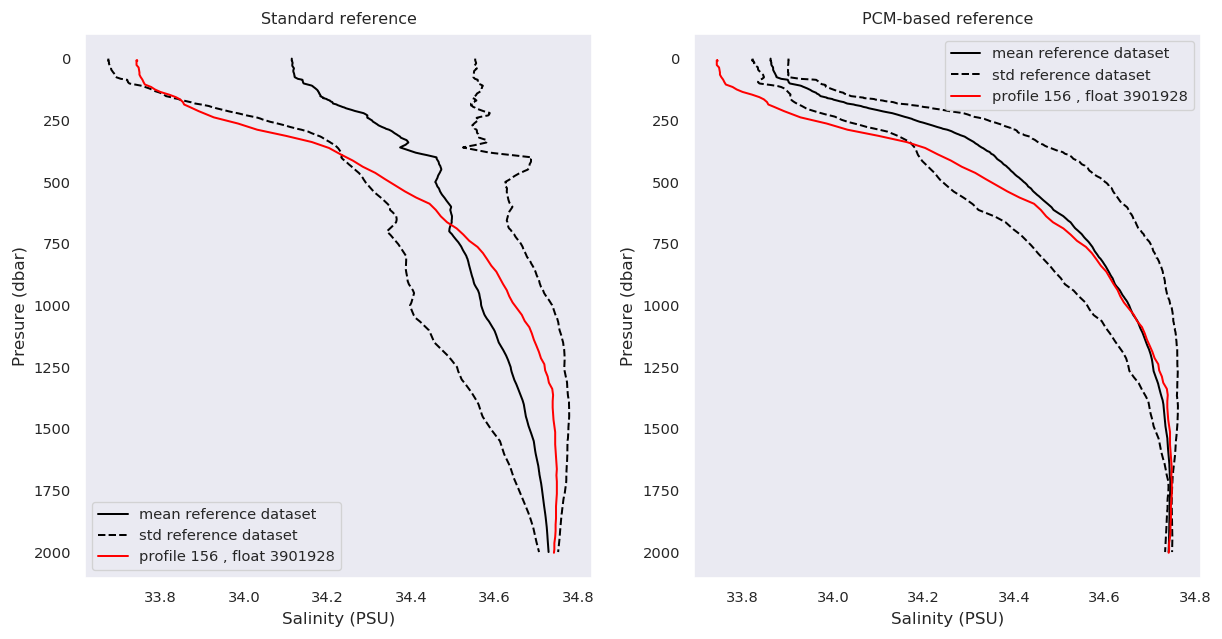

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(
            12, 6), dpi=120, facecolor='w', edgecolor='k')

ax[0].plot(mean_sal, ds_refi['PRES_INTERPOLATED'].values, 'k', label='mean reference dataset');
ax[0].plot(mean_sal + std_sal, ds_refi['PRES_INTERPOLATED'].values, 'k--', label='std reference dataset')
ax[0].plot(mean_sal - std_sal, ds_refi['PRES_INTERPOLATED'].values, 'k--')
ax[0].plot(ds_f['PSAL'].values[0], ds_f['PRES'].values[0], 'r', label='profile ' + str(prof_num)+ ' , float ' + str(float_WMO));
ax[0].invert_yaxis()
ax[0].set_ylabel('Presure (dbar)', fontsize=10);
ax[0].set_xlabel('Salinity (PSU)', fontsize=10);
ax[0].set_title('Standard reference')
ax[0].legend()

ax[1].plot(mean_sal_class, ds_ref_classi['PRES_INTERPOLATED'].values, 'k', label='mean reference dataset');
ax[1].plot(mean_sal_class + std_sal_class, ds_ref_classi['PRES_INTERPOLATED'].values, 'k--', label='std reference dataset');
ax[1].plot(mean_sal_class - std_sal_class, ds_ref_classi['PRES_INTERPOLATED'].values, 'k--');
ax[1].plot(ds_f['PSAL'].values[0], ds_f['PRES'].values[0], 'r', label='profile ' + str(prof_num)+ ' , float ' + str(float_WMO));
ax[1].invert_yaxis()
ax[1].set_ylabel('Presure (dbar)', fontsize=10);
ax[1].set_xlabel('Salinity (PSU)', fontsize=10);
ax[1].set_title('PCM-based reference')
ax[1].legend()

Print all profiles

Text(0.5, 1.0, 'PCM-based reference')

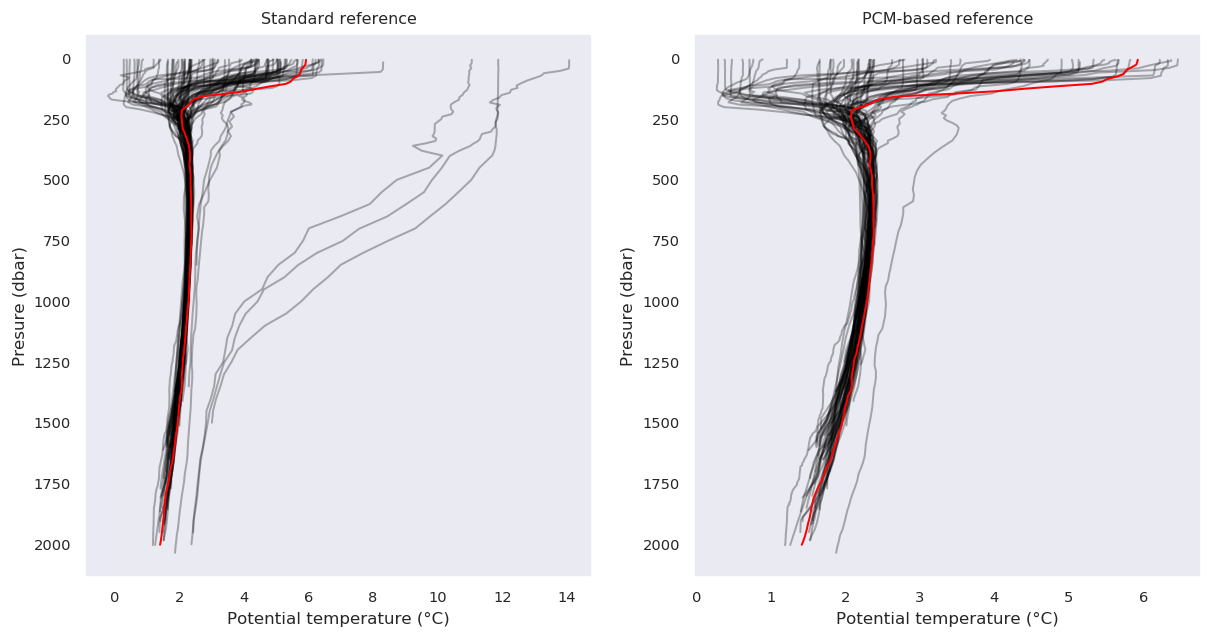

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(
            12, 6), dpi=120, facecolor='w', edgecolor='k')

for i in range(len(ds_ref['n_profiles'])):
    ax[0].plot(ds_ref['ptmp'].isel(n_profiles = i), ds_ref['pres'].isel(n_profiles = i), 'k', alpha=0.3);
ax[0].plot(ds_f['ptmp'].values[0], ds_f['PRES'].values[0], 'r', label='profile ' + str(prof_num)+ ' , float ' + str(float_WMO));
ax[0].invert_yaxis()
ax[0].set_ylabel('Presure (dbar)', fontsize=10);
ax[0].set_xlabel('Potential temperature (°C)', fontsize=10);
ax[0].set_title('Standard reference')
#ax[0].legend()

for i in range(len(ds_ref_class['n_profiles'])):
    ax[1].plot(ds_ref_class['ptmp'].isel(n_profiles = i), ds_ref_class['pres'].isel(n_profiles = i), 'k', alpha=0.3);
ax[1].plot(ds_f['ptmp'].values[0], ds_f['PRES'].values[0], 'r', label='profile ' + str(prof_num)+ ' , float ' + str(float_WMO));
ax[1].invert_yaxis()
ax[1].set_ylabel('Presure (dbar)', fontsize=10);
ax[1].set_xlabel('Potential temperature (°C)', fontsize=10);
ax[1].set_title('PCM-based reference')
#ax[1].legend()

Text(0.5, 1.0, 'PCM-based reference')

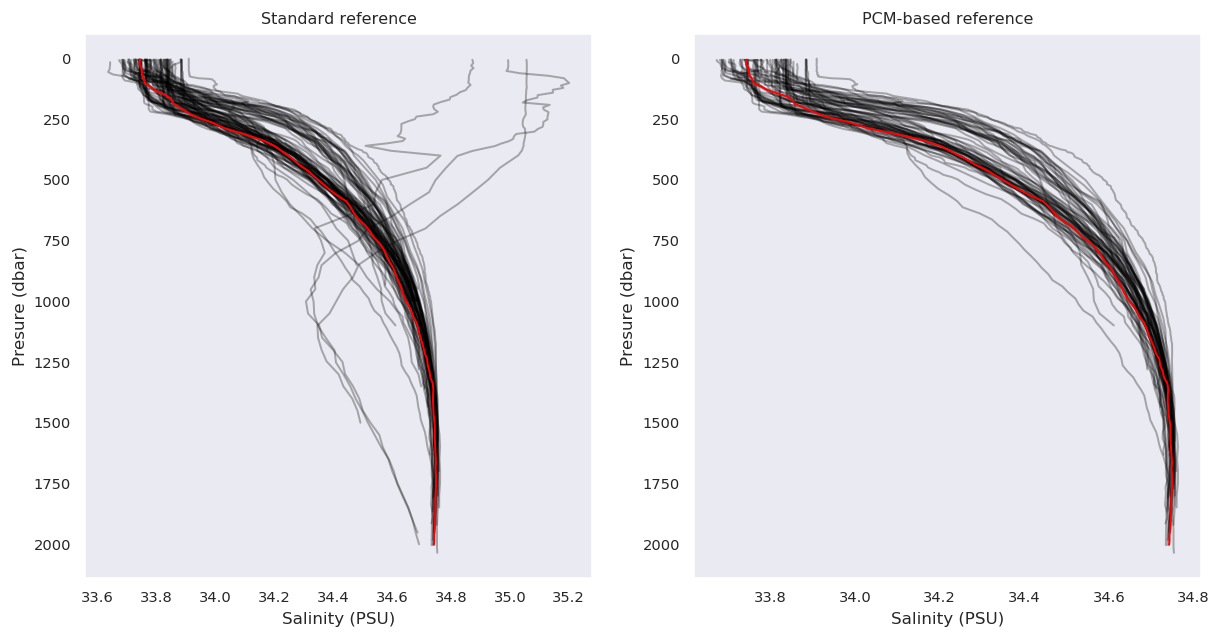

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(
            12, 6), dpi=120, facecolor='w', edgecolor='k')

for i in range(len(ds_ref['n_profiles'])):
    ax[0].plot(ds_ref['sal'].isel(n_profiles = i), ds_ref['pres'].isel(n_profiles = i), 'k', alpha=0.3);
ax[0].plot(ds_f['PSAL'].values[0], ds_f['PRES'].values[0], 'r', label='profile ' + str(prof_num)+ ' , float ' + str(float_WMO));
ax[0].invert_yaxis()
ax[0].set_ylabel('Presure (dbar)', fontsize=10);
ax[0].set_xlabel('Salinity (PSU)', fontsize=10);
ax[0].set_title('Standard reference')
#ax[0].legend()

for i in range(len(ds_ref_class['n_profiles'])):
    ax[1].plot(ds_ref_class['sal'].isel(n_profiles = i), ds_ref_class['pres'].isel(n_profiles = i), 'k', alpha=0.3);
ax[1].plot(ds_f['PSAL'].values[0], ds_f['PRES'].values[0], 'r', label='profile ' + str(prof_num)+ ' , float ' + str(float_WMO));
ax[1].invert_yaxis()
ax[1].set_ylabel('Presure (dbar)', fontsize=10);
ax[1].set_xlabel('Salinity (PSU)', fontsize=10);
ax[1].set_title('PCM-based reference')
#ax[1].legend()

Plot ellipses with and without class selection

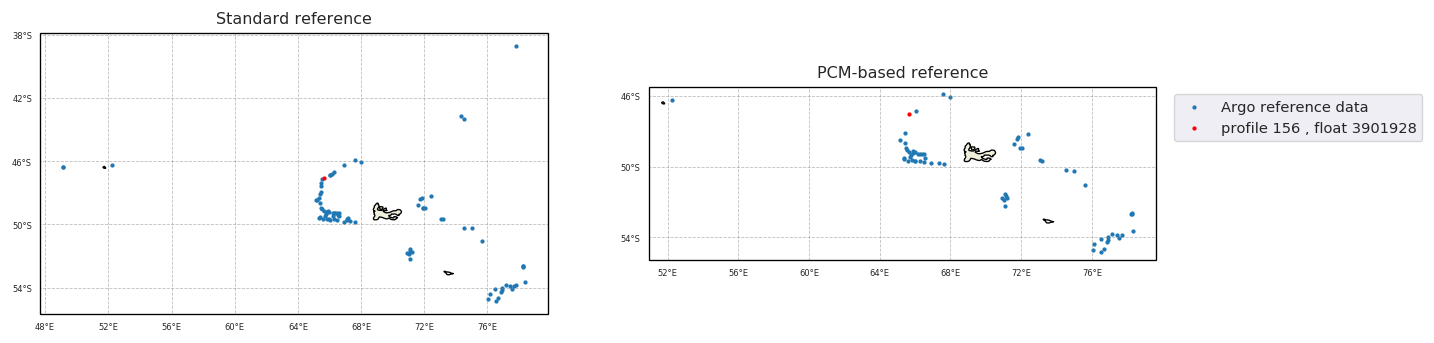

In [18]:
#selected_float_index = [i for i, isource in enumerate(ds_out['source'].values) if isource == 'selected_float']

proj=ccrs.PlateCarree()
subplot_kw = {'projection': proj}
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(
            12, 6), dpi=120, facecolor='w', edgecolor='k', subplot_kw=subplot_kw)

# without class selection
p1 = ax[0].scatter(ds_ref['long'], ds_ref['lat'], s=3, transform=proj, label='Argo reference data')
p2 = ax[0].scatter(ds_f['LONGITUDE'], ds_f['LATITUDE'], s=3, color = 'r', transform=proj, label='profile ' + str(prof_num)+ ' , float ' + str(float_WMO))

land_feature = cfeature.NaturalEarthFeature(
            category='physical', name='land', scale='50m', facecolor=[0.9375, 0.9375, 0.859375])
ax[0].add_feature(land_feature, edgecolor='black')

defaults = {'linewidth': .5, 'color': 'gray', 'alpha': 0.5, 'linestyle': '--'}
gl = ax[0].gridlines(crs=ax[0].projection,draw_labels=True, **defaults)
gl.xlocator = mticker.FixedLocator(np.arange(-180, 180+1, 4))
gl.ylocator = mticker.FixedLocator(np.arange(-90, 90+1, 4))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'fontsize': 5}
gl.ylabel_style = {'fontsize': 5}
gl.xlabels_top = False
gl.ylabels_right = False
ax[0].set_title('Standard reference')

# with class selection
p1 = ax[1].scatter(ds_ref_class['long'], ds_ref_class['lat'], s=3, transform=proj, label='Argo reference data')
p2 = ax[1].scatter(ds_f['LONGITUDE'], ds_f['LATITUDE'], s=3, color = 'r', transform=proj, label='profile ' + str(prof_num)+ ' , float ' + str(float_WMO))

land_feature = cfeature.NaturalEarthFeature(
            category='physical', name='land', scale='50m', facecolor=[0.9375, 0.9375, 0.859375])
ax[1].add_feature(land_feature, edgecolor='black')

defaults = {'linewidth': .5, 'color': 'gray', 'alpha': 0.5, 'linestyle': '--'}
gl = ax[1].gridlines(crs=ax[1].projection,draw_labels=True, **defaults)
gl.xlocator = mticker.FixedLocator(np.arange(-180, 180+1, 4))
gl.ylocator = mticker.FixedLocator(np.arange(-90, 90+1, 4))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'fontsize': 5}
gl.ylabel_style = {'fontsize': 5}
gl.xlabels_top = False
gl.ylabels_right = False
ax[1].set_title('PCM-based reference')

ax[1].legend(bbox_to_anchor=(1.02, 1), loc='upper left')

plot number of reference profiles per profile

In [30]:
# load standard reference data
file_path1 = 'mat_files/n_ref_prof.mat'
mat_dict = sp.io.loadmat(file_path1)
# load standard PCM based data
file_path2 = 'mat_files/n_ref_prof_class_k3.mat'
mat_dict_class = sp.io.loadmat(file_path2)

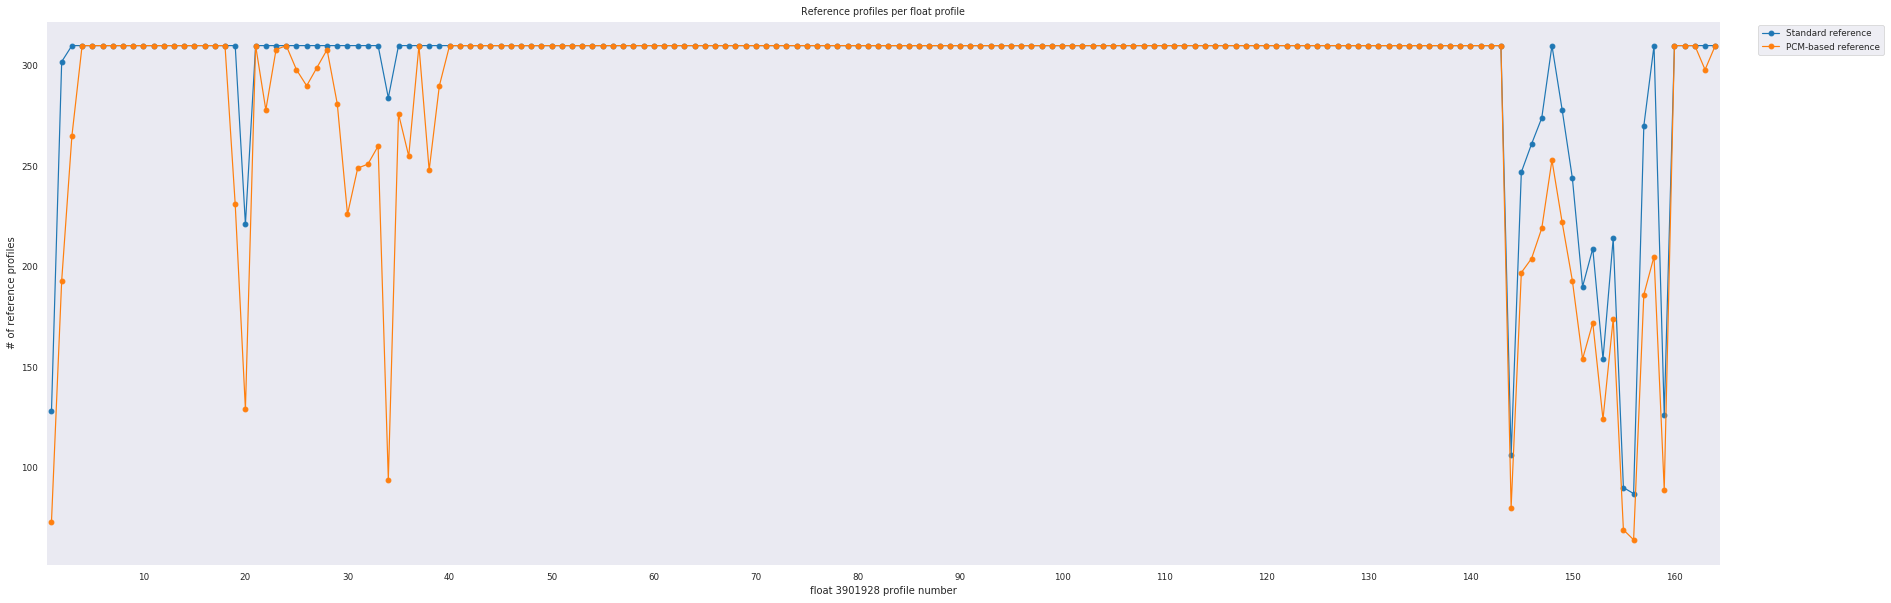

In [52]:
labels = np.arange(0,len(mat_dict['n_ref_prof'][0])+1,10)

x = np.arange(1,len(mat_dict['n_ref_prof'][0])+1)  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(30, 10))
rects1 = ax.plot(x, mat_dict['n_ref_prof'][0], 'o-', label='Standard reference')
rects2 = ax.plot(x, mat_dict_class['n_ref_prof'][0], 'o-', label='PCM-based reference')

ax.set_ylabel('# of reference profiles', fontsize=10)
ax.set_xlabel('float ' + str(float_WMO) + ' profile number', fontsize=10)
ax.set_title('Reference profiles per float profile')
ax.set_xticks(labels)
ax.set_xlim([0.5,len(mat_dict['n_ref_prof'][0])+0.5])
#ax.set_xticklabels(labels)
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left')